In [5]:
import pandas as pd
from cartopy import crs as ccrs
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean.cm as cmo
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import warnings
import gsw

In [17]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':cmo.matter_r,'units':r'pmol kg$^{-1}$'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK'},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C'},
    'ct':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C'},
    'sa':{'conversion':1,'cmap':cmocean.cm.haline,'units':r'g kg$^{-1}$'},
    'so':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu'},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu'}, 
    'density':{'conversion':1,'cmap':cmocean.cm.dense,'units':r'kg m$^{-3}$'},
    'rho2':{'conversion':1,'cmap':cmocean.cm.dense,'units':r'kg m$^{-3}$'},

    'agessc':{'conversion':1,'cmap':cmocean.cm.speed,'units':'years'}
}

In [8]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/" + x
ds_zonal_avg = xr.open_dataset(datadir("SO_Tracer_Zonal_sigma2.nc"))
ds_zonal_avg = ds_zonal_avg.where(ds_zonal_avg.rho2 != np.nan)

In [52]:
average_period = lambda ds, time_slice: ds.sel(time = time_slice).mean("time", skipna = True) 

def plot_zonal_average_period(ds_zonal_avg, variable, variable_name, 
                              time_slices, 
                              vmin=None, vmax=None, levels=None, extend = "both"):

        
        conversion = variable_kwargs[variable]["conversion"]
        cmap = variable_kwargs[variable]["cmap"]
        variable_units = variable_kwargs[variable]["units"]
    
        t0, t1 = time_slices[j]
        avg_var = average_period(ds_zonal_avg[variable], slice(t0, t1))
        avg_var = conversion * avg_var

        if vmin is None or vmax is None or levels is None:
            warnings.warn(
                "One or more of vmin, vmax, or levels was not provided. "
                "Automatically calculating all three from the data range."
            )
            vmin = float(avg_var.min())
            vmax = float(avg_var.max())
            n_levels = 21
            levels = np.linspace(vmin, vmax, n_levels)
            levels = np.round(levels, decimals = 2)
    
        cb = avg_var.sel(exp = expt).plot.contourf(x = "geolat", y = "z_l", ax = a, 
                                          vmin = vmin, vmax = vmax, levels = levels, 
                                          cmap = cmap, add_colorbar = False, extend = extend)
        a.vlines([-50], color  = "white", ymin = avg_var.z_l.min(), ymax = avg_var.z_l.max())
        a.set_title("")
        a.set_ylabel("")
        a.set_xlabel("")
        a.set_facecolor("#3A3B3C") 
        a.tick_params(bottom=True, left=True)
        a.grid(alpha = 0)
        a.text(0.88, 0.01, expt.capitalize() + f"\n{t0}-{t1}", color='white', fontsize=10,
               ha='center', va='bottom', multialignment='center', transform=a.transAxes)
        return cb

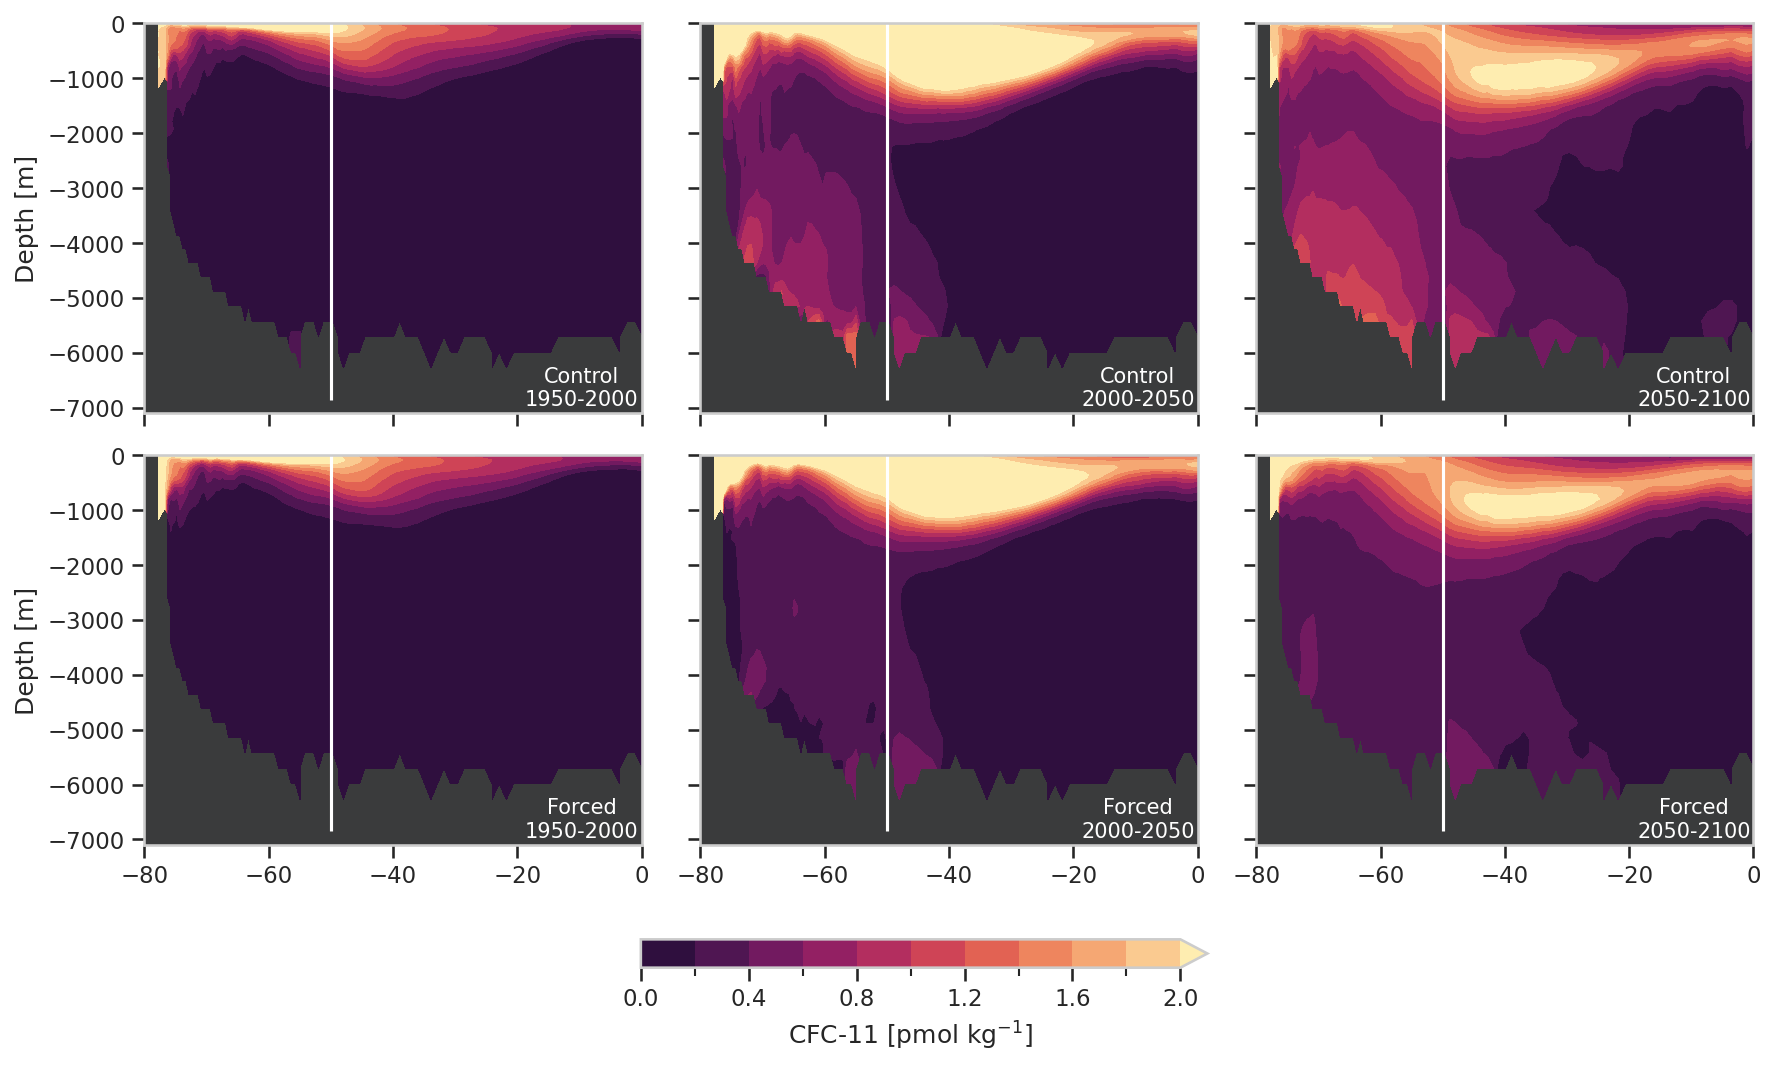

In [53]:
time_slices = [("1950", "2000"), ("2000", "2050"),  ("2050", "2100")]
expts = ["control", "forced"]
variable = "cfc11"; variable_name = "CFC-11"; 
vmin = 0; vmax = 2; levels = np.arange(vmin, vmax + 1e-14, 0.2)
extend = "max"

fig, axes = plt.subplots(2, 3, figsize = (12, 7), sharey = True, sharex = True)

for (i, expt) in enumerate(expts):
    ax = axes[i]
    for (j, a) in enumerate(ax):

        cb = plot_zonal_average_period(ds_zonal_avg, variable, variable_name, 
                                      time_slices, 
                                      vmin, vmax, levels, extend)
        
    ax[0].set_ylabel("Depth [m]")
    ax[0].set_xlim(-80, 0)
    ax[0].set_ylim(-7100, 0)

fig.tight_layout()
variable_units = variable_kwargs[variable]["units"]
fig.colorbar(cb, ax = axes, orientation = "horizontal", fraction = 0.03, pad = 0.1, 
            label = variable_name + f" [{variable_units}]")

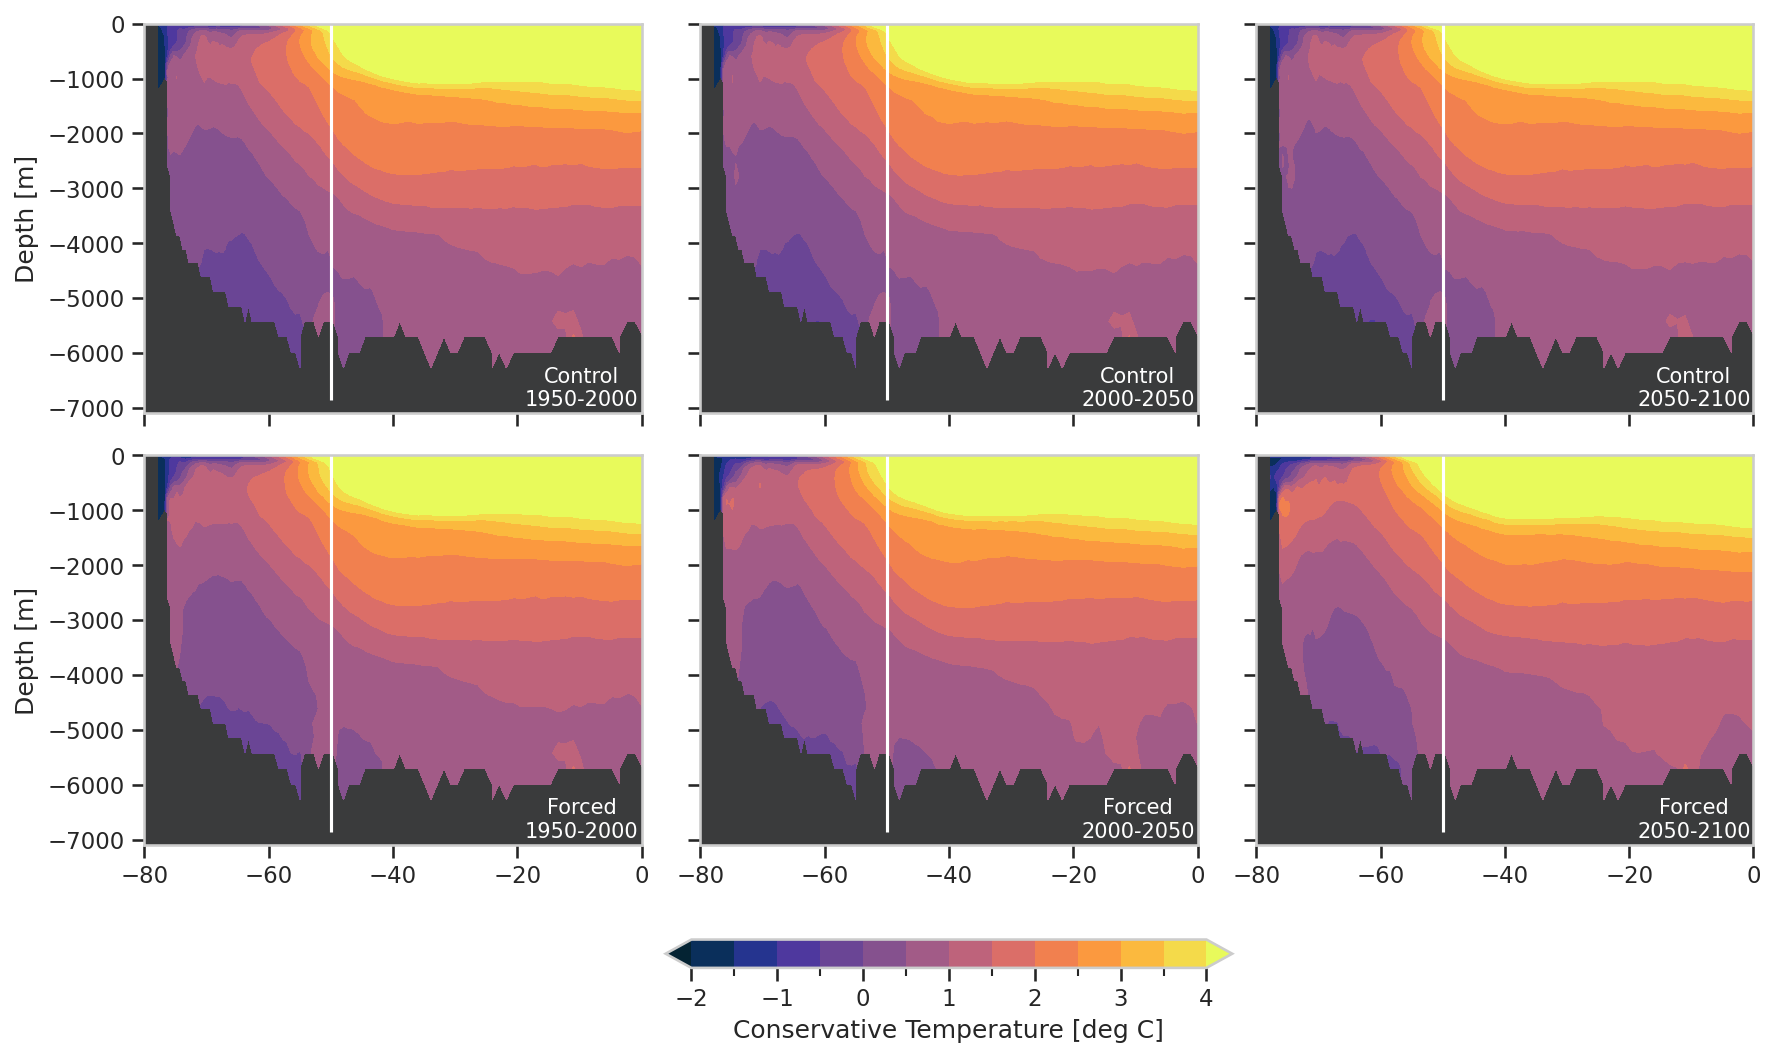

In [69]:
time_slices = [("1950", "2000"), ("2000", "2050"),  ("2050", "2100")]
expts = ["control", "forced"]
variable = "ct"; variable_name = "Conservative Temperature"; 
vmin = -2; vmax = 4; levels = np.arange(vmin, vmax + 1e-14, 0.5)
extend = "both"

fig, axes = plt.subplots(2, 3, figsize = (12, 7), sharey = True, sharex = True)

for (i, expt) in enumerate(expts):
    ax = axes[i]
    for (j, a) in enumerate(ax):

        cb = plot_zonal_average_period(ds_zonal_avg, variable, variable_name, 
                                      time_slices, 
                                      vmin, vmax, levels, extend)
        
    ax[0].set_ylabel("Depth [m]")
    ax[0].set_xlim(-80, 0)
    ax[0].set_ylim(-7100, 0)

fig.tight_layout()
variable_units = variable_kwargs[variable]["units"]
fig.colorbar(cb, ax = axes, orientation = "horizontal", fraction = 0.03, pad = 0.1, 
            label = variable_name + f" [{variable_units}]")

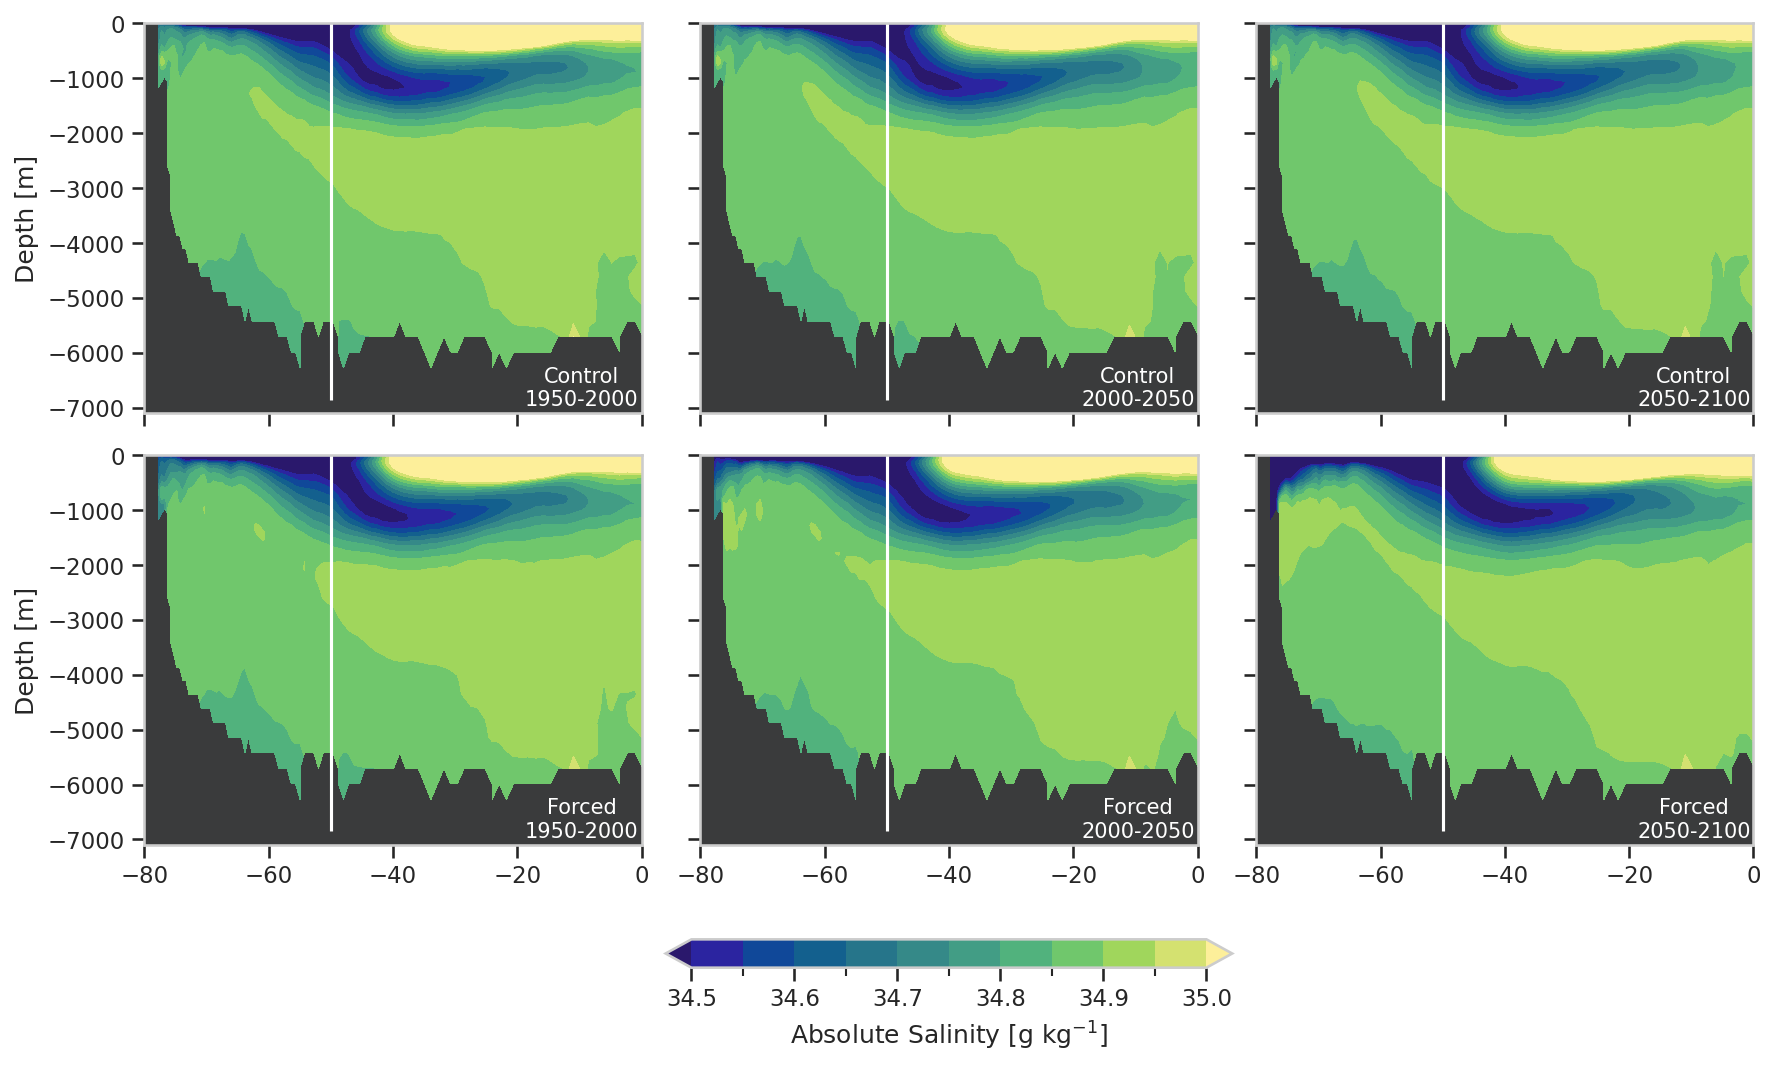

In [55]:
time_slices = [("1950", "2000"), ("2000", "2050"),  ("2050", "2100")]
expts = ["control", "forced"]
variable = "sa"; variable_name = "Absolute Salinity"; 
vmin = 34.5; vmax = 35; levels = np.arange(vmin, vmax + 1e-14, 0.05)
extend = "both"

fig, axes = plt.subplots(2, 3, figsize = (12, 7), sharey = True, sharex = True)

for (i, expt) in enumerate(expts):
    ax = axes[i]
    for (j, a) in enumerate(ax):

        cb = plot_zonal_average_period(ds_zonal_avg, variable, variable_name, 
                                      time_slices, 
                                      vmin, vmax, levels, extend)
        
    ax[0].set_ylabel("Depth [m]")
    ax[0].set_xlim(-80, 0)
    ax[0].set_ylim(-7100, 0)

fig.tight_layout()
variable_units = variable_kwargs[variable]["units"]
fig.colorbar(cb, ax = axes, orientation = "horizontal", fraction = 0.03, pad = 0.1, 
            label = variable_name + f" [{variable_units}]")

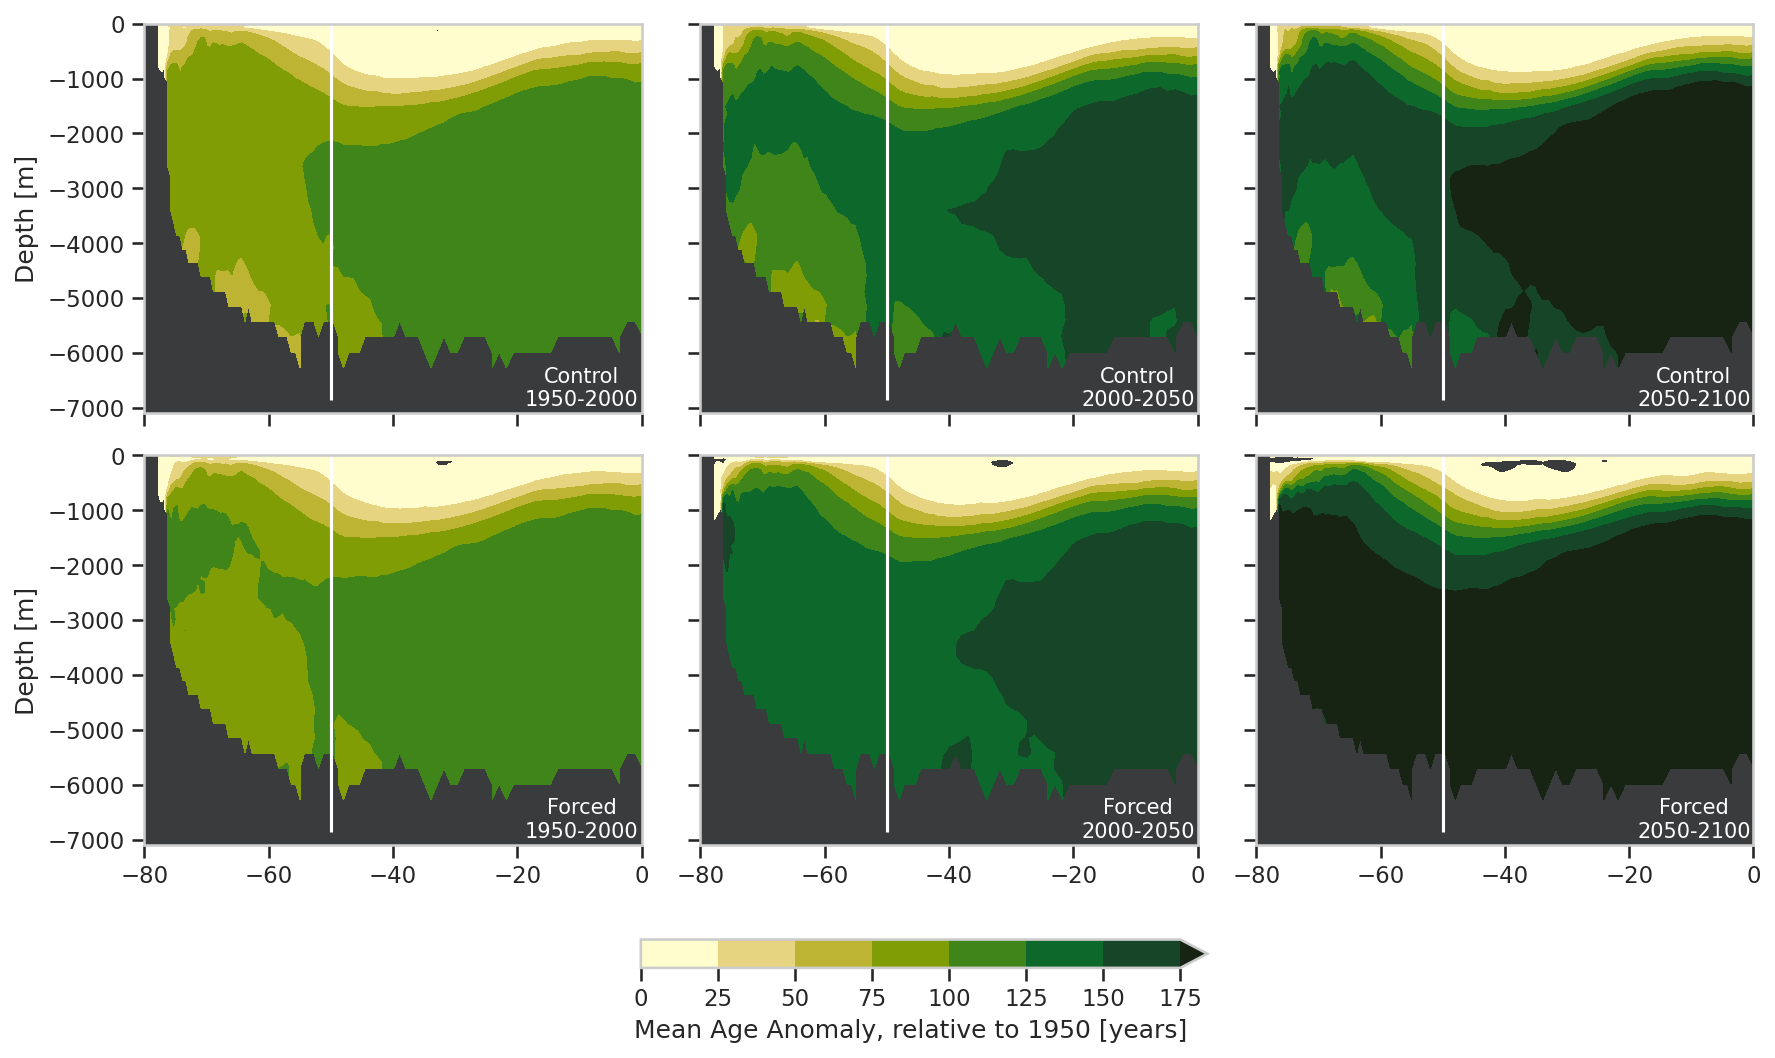

In [56]:
time_slices = [("1950", "2000"), ("2000", "2050"),  ("2050", "2100")]
expts = ["control", "forced"]
variable = "agessc"; variable_name = "Mean Age Anomaly, relative to 1950"; 
vmin = 0; vmax = 200;levels = np.arange(vmin, vmax + 1e-14, 25)
extend = "both"

fig, axes = plt.subplots(2, 3, figsize = (12, 7), sharey = True, sharex = True)

for (i, expt) in enumerate(expts):
    ax = axes[i]
    for (j, a) in enumerate(ax):
        
        cb = plot_zonal_average_period(ds_zonal_avg - ds_zonal_avg.isel(time = 0), variable, variable_name, 
                                      time_slices, 
                                      vmin, vmax, levels, extend)
        
    ax[0].set_ylabel("Depth [m]")
    ax[0].set_xlim(-80, 0)
    ax[0].set_ylim(-7100, 0)

fig.tight_layout()
variable_units = variable_kwargs[variable]["units"]
fig.colorbar(cb, ax = axes, orientation = "horizontal", fraction = 0.03, pad = 0.1, 
            label = variable_name + f" [{variable_units}]")

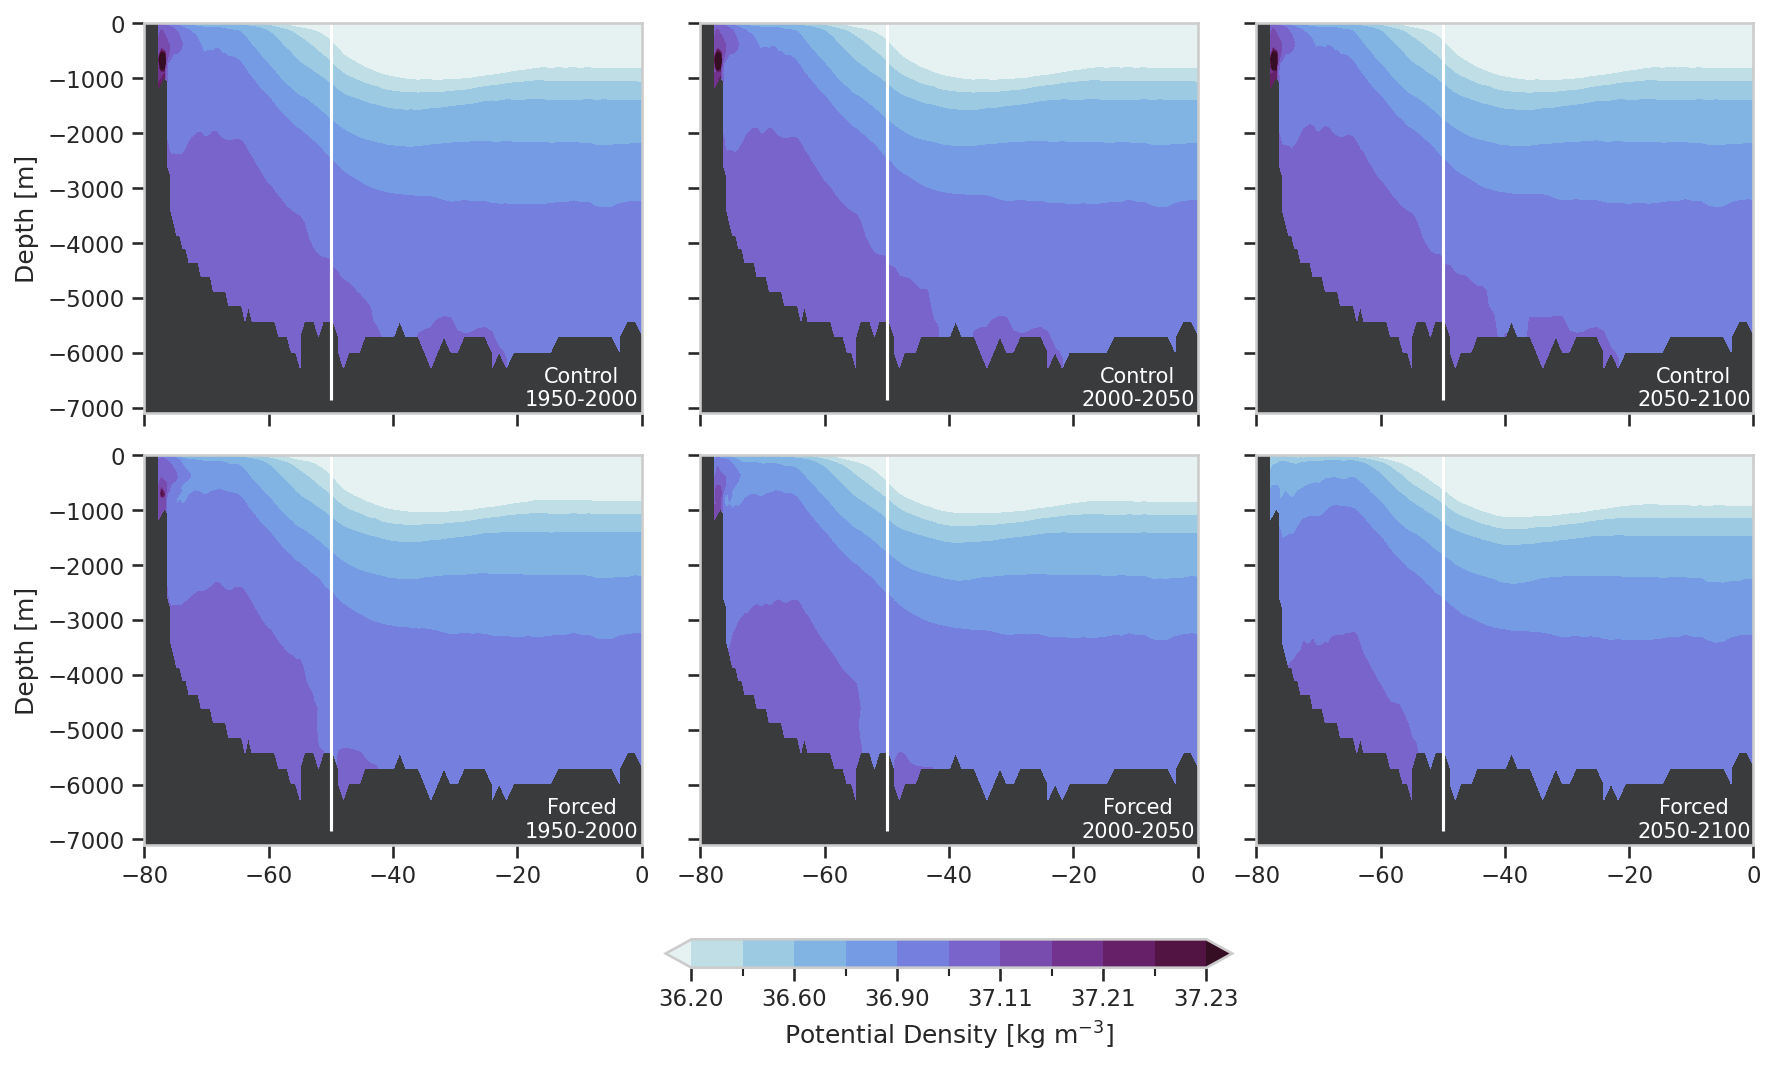

In [57]:
time_slices = [("1950", "2000"), ("2000", "2050"),  ("2050", "2100")]
expts = ["control", "forced"]
variable = "rho2"; variable_name = "Potential Density"; 

levels = np.arange(36.2, 37.4, .2) 
levels = 1.0 * np.sort(np.append(levels, [36.9, 37.11, 37.21, 37.22, 37.23]))

vmin = levels.min(); vmax = levels.max();
extend = "both"

fig, axes = plt.subplots(2, 3, figsize = (12, 7), sharey = True, sharex = True)

for (i, expt) in enumerate(expts):
    ax = axes[i]
    for (j, a) in enumerate(ax):

        cb = plot_zonal_average_period(ds_zonal_avg, variable, variable_name, 
                                      time_slices, 
                                      vmin, vmax, levels, extend)
        
    ax[0].set_ylabel("Depth [m]")
    ax[0].set_xlim(-80, 0)
    ax[0].set_ylim(-7100, 0)

fig.tight_layout()
variable_units = variable_kwargs[variable]["units"]
fig.colorbar(cb, ax = axes, orientation = "horizontal", fraction = 0.03, pad = 0.1, 
            label = variable_name + f" [{variable_units}]")

In [58]:
get_baselines = lambda ds_zonal_avg, var: average_period(ds_zonal_avg[var], slice("1950", "2000"))

ds_zonal_avg["rho2_baseline"] = get_baselines(ds_zonal_avg, "rho2")
ds_zonal_avg["ct_baseline"] = get_baselines(ds_zonal_avg, "ct")
ds_zonal_avg["sa_baseline"] = get_baselines(ds_zonal_avg, "sa")


p_ref = 2000 #2000 dbar reference pressure 

# Calculate thermal expansion coefficient alpha (1/K) at reference pressure
ds_zonal_avg['alpha_baseline'] = xr.apply_ufunc(
    gsw.alpha, ds_zonal_avg["sa_baseline"], ds_zonal_avg["ct_baseline"], p_ref, dask="parallelized"
)

# Calculate the haline contraction coefficient beta (kg/g) at reference pressure
ds_zonal_avg['beta_baseline'] = xr.apply_ufunc(
    gsw.beta, ds_zonal_avg["sa_baseline"], ds_zonal_avg["ct_baseline"], p_ref, dask="parallelized"
)

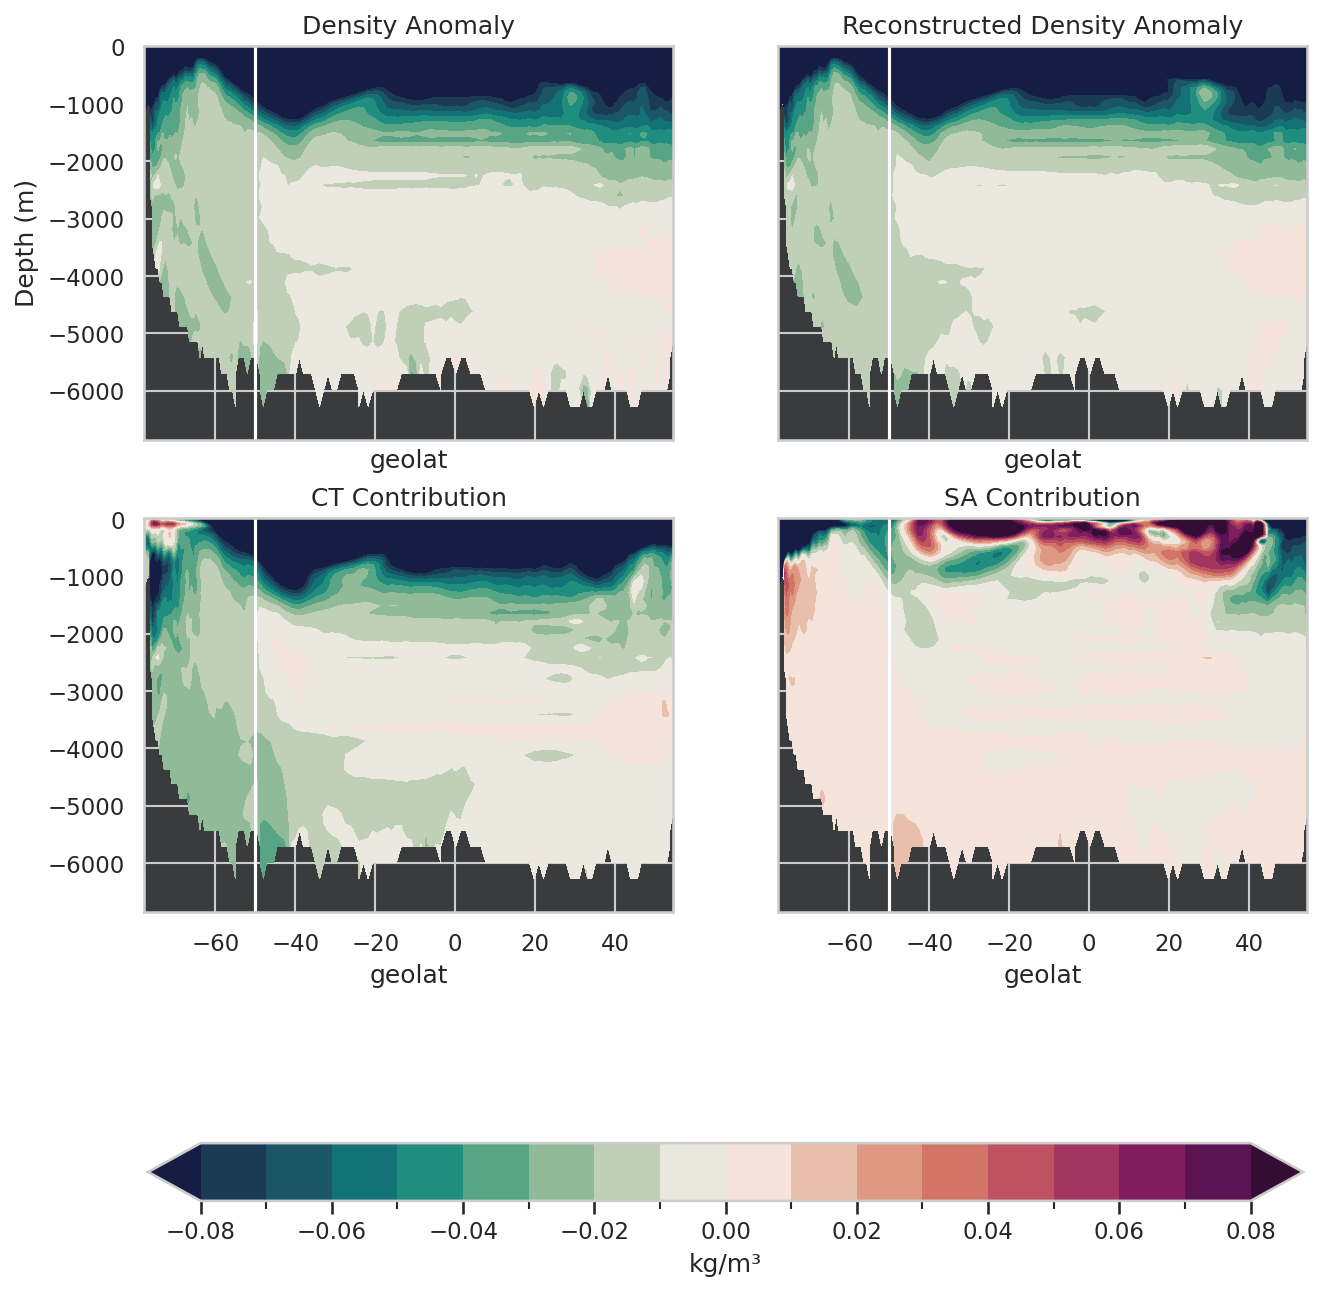

In [61]:
# Compute the reconstructed anomaly
ds_zonal_avg["rho2_anomaly_reconstructed"] = (
    ds_zonal_avg["rho2_anomaly_ct_contrib"] + ds_zonal_avg["rho2_anomaly_sa_contrib"]
)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# Define variables and titles
variables = [
    ("rho2_anomaly", "Density Anomaly"),
    ("rho2_anomaly_reconstructed", "Reconstructed Density Anomaly"),
    ("rho2_anomaly_ct_contrib", "CT Contribution"),
    ("rho2_anomaly_sa_contrib", "SA Contribution")
]

vmin, vmax = -0.08, 0.08
levels = np.arange(vmin, vmax + 1e-14, 0.01)
# Plot each panel
for ax, (var, title) in zip(axs.flat, variables):
     
    pcm = ds_zonal_avg[var].sel(exp = "forced").plot.contourf(ax = ax, 
                                                     x = "geolat", y = "z_l", 
                                                     vmin=vmin, vmax=vmax, levels = levels,
                                                     add_colorbar = False, 
                                                    cmap = cmo.curl, extend = "both")
    ax.vlines([-50], color  = "white", ymin = ds_zonal_avg.z_l.min(), ymax = ds_zonal_avg.z_l.max())

    ax.set_title(title)
    ax.set_ylabel("")
    ax.set_facecolor("#3A3B3C") 


# ax.set_xlabel("Latitude")

axs[0, 0].set_ylabel("Depth (m)")

fig.colorbar(pcm, ax=axs, label="kg/m³", orientation = "horizontal", fraction = 0.05, pad = 0.2)
